# 4 лекция по мат статистике в python от Нетология. Кейс-стади.

In [0]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns

%matplotlib inline

Загрузим датасет 'Faulty-steel-plates'

In [2]:
import io
import requests
url="http://yustiks.ru/faults.csv"
dataset_temp=pd.read_csv(url) 
dataset_temp.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


There are 34 fields. The first 27 fields describe some kind of steel plate faults seen in images. Unfortunately, there is no other information that I know of to describe these columns.

*    X_Minimum
 *   X_Maximum
*    Y_Minimum
*    Y_Maximum
*    Pixels_Areas
*    X_Perimeter
*    Y_Perimeter
*    Sum_of_Luminosity
*    Minimum_of_Luminosity
*    Maximum_of_Luminosity
*    Length_of_Conveyer
*    TypeOfSteel_A300
*    TypeOfSteel_A400
*    Steel_Plate_Thickness
*    Edges_Index
*    Empty_Index
*    Square_Index
*    Outside_X_Index
*    Edges_X_Index
*    Edges_Y_Index
*    Outside_Global_Index
*    LogOfAreas
*    Log_X_Index
*    Log_Y_Index
*    Orientation_Index
*    Luminosity_Index
*    SigmoidOfAreas

The last seven columns are one hot encoded classes, i.e. if the plate fault is classified as "Stains" there will be a 1 in that column and 0's in the other columns. If you are unfamiliar with one hot encoding, just know that the last seven columns are your class labels.

*    Pastry
*    Z_Scratch
*    K_Scatch
*    Stains
*    Dirtiness
*    Bumps
*    Other_Faults


Первые 27 колонок данной таблицы являются колонками для предсказаний класса.

In [3]:
data = dataset_temp.iloc[:,:27]
data[:4]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212


Посмотрим частотный график данных колонок (график histograms):

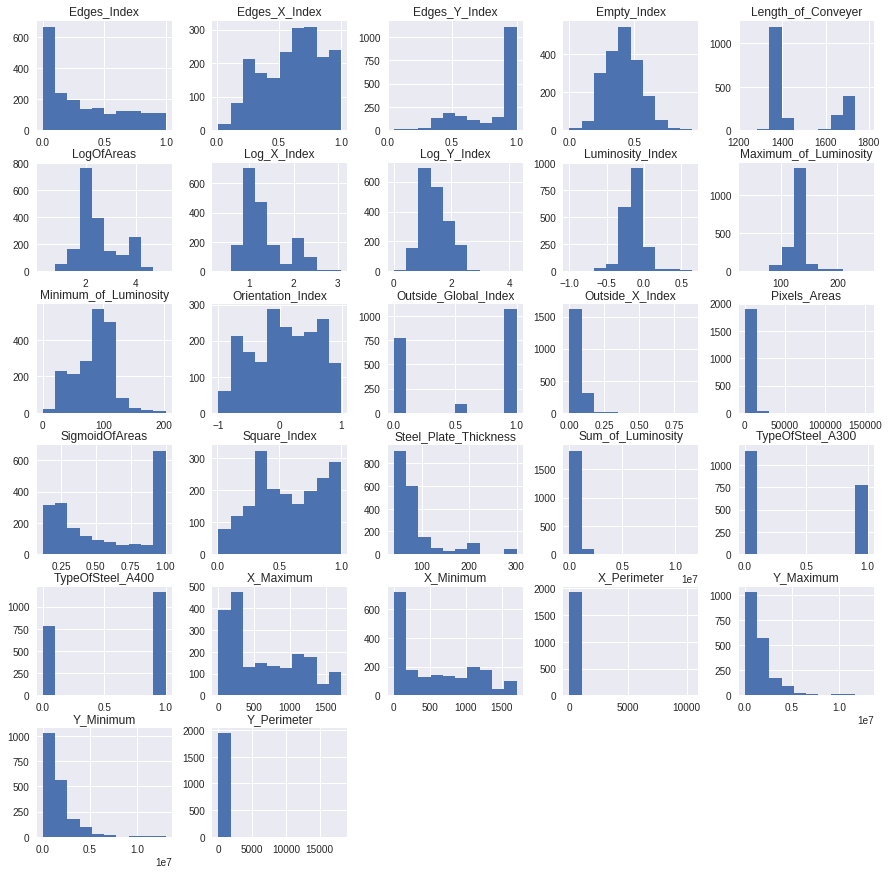

In [0]:

data.hist(figsize=(15,15))
plt.show()

Из данных графиков можно увидеть, что Outside_Global_Index, TypeOfSteel_A300, TypeOfSteel_A400 являются дискретными величинами со значениями [0, 0.5, 1], [0,1], [0,1] соответственно (распределение Бернулли). 

Можно также заметить, что такие переменные, как Empty_Index, Log_Y_Index, Luminosity_Index являются нормальным распределением Гаусса. 

Выделим колонки в отдельный список

In [0]:
headers = list(data.columns.values)

Нормализуем параметры

In [18]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

np_scaled = min_max_scaler.fit_transform(data)
df_norm = pd.DataFrame(np_scaled)
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,-0.950733,-0.946167,-0.959296,-0.959291,-0.996528,-0.997128,-0.995262,-0.995864,-0.251232,-0.342593,0.622575,1.0,-1.0,-0.692308,-0.899920,-0.488293,-0.650096,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.242832,-0.609987,-0.609985,-0.998611,-0.998468,-0.996805,-0.998077,-0.172414,-0.203704,0.622575,1.0,-1.0,-0.692308,0.536777,-0.196313,-0.599476,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.027501,-0.761620,-0.761619,-0.999096,-0.998851,-0.998017,-0.998668,-0.024631,-0.185185,0.396825,1.0,-1.0,-0.538462,0.951367,-0.274076,-0.344560,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,0.001755,-0.944125,-0.944120,-0.997720,-0.997894,-0.995152,-0.996765,-0.024631,-0.175926,-0.555556,-1.0,1.0,0.923077,0.464429,-0.064943,-0.702934,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,0.523698,-0.924294,-0.924257,-0.968464,-0.988896,-0.971462,-0.957437,-0.635468,-0.175926,-0.555556,-1.0,1.0,0.115385,-0.860330,-0.049476,-0.883231,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


При нормализации стираются названия колонок, поэтому необходимо восстановить их:

In [17]:
df_norm.columns = headers
df_norm.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,-0.950733,-0.946167,-0.959296,-0.959291,-0.996528,-0.997128,-0.995262,-0.995864,-0.251232,-0.342593,0.622575,1.0,-1.0,-0.692308,-0.899920,-0.488293,-0.650096,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.242832,-0.609987,-0.609985,-0.998611,-0.998468,-0.996805,-0.998077,-0.172414,-0.203704,0.622575,1.0,-1.0,-0.692308,0.536777,-0.196313,-0.599476,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.027501,-0.761620,-0.761619,-0.999096,-0.998851,-0.998017,-0.998668,-0.024631,-0.185185,0.396825,1.0,-1.0,-0.538462,0.951367,-0.274076,-0.344560,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,0.001755,-0.944125,-0.944120,-0.997720,-0.997894,-0.995152,-0.996765,-0.024631,-0.175926,-0.555556,-1.0,1.0,0.923077,0.464429,-0.064943,-0.702934,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,0.523698,-0.924294,-0.924257,-0.968464,-0.988896,-0.971462,-0.957437,-0.635468,-0.175926,-0.555556,-1.0,1.0,0.115385,-0.860330,-0.049476,-0.883231,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


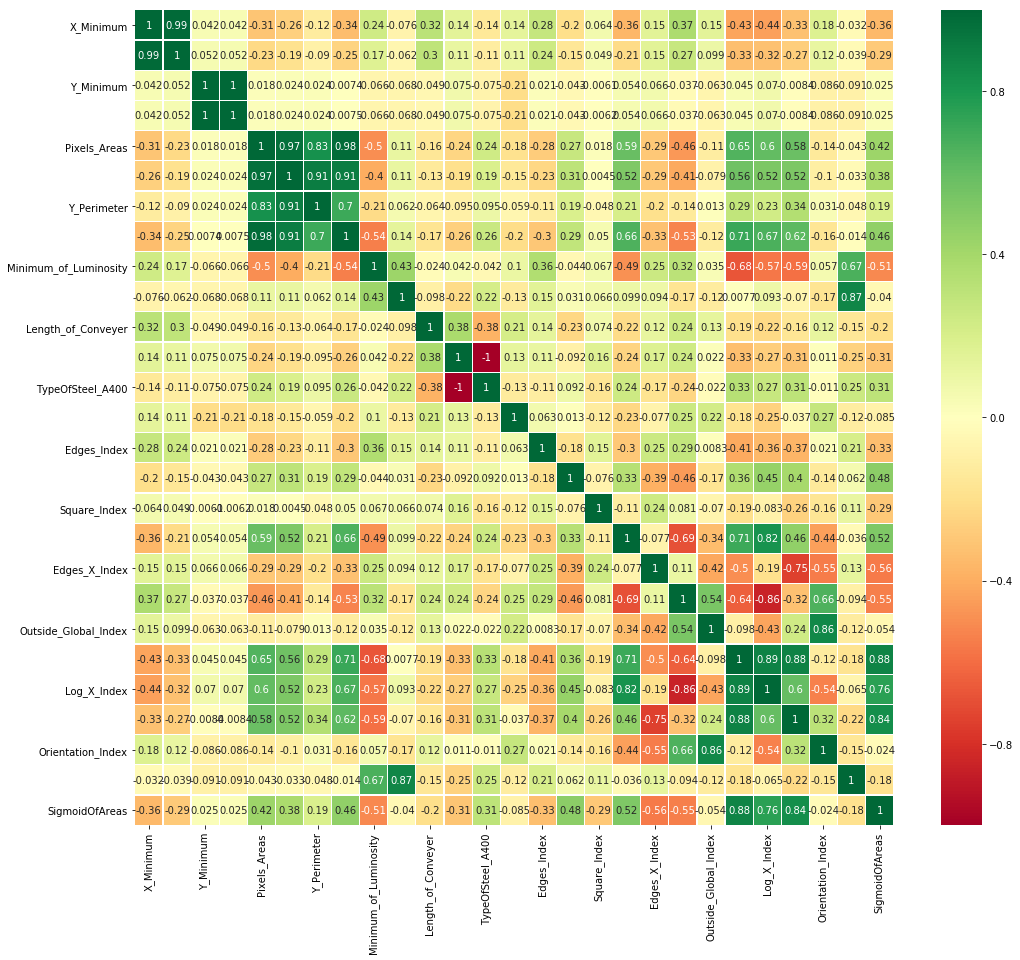

In [16]:
sns.heatmap(df_norm.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(17,15)
plt.show()

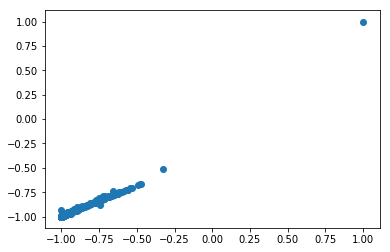

In [10]:
plt.scatter(df_norm['Sum_of_Luminosity'], df_norm['Pixels_Areas'])
plt.show()

In [19]:
# Create correlation matrix
corr_matrix = df_norm.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

[1, 3, 5, 7, 12]


In [20]:
df_norm = df_norm.drop(df_norm[to_drop], axis=1)
df_norm.head()


,0,2,4,6,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,-0.950733,-0.959296,-0.996528,-0.995262,-0.251232,-0.342593,0.622575,1.0,-0.692308,-0.899920,-0.488293,-0.650096,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.609987,-0.998611,-0.996805,-0.172414,-0.203704,0.622575,1.0,-0.692308,0.536777,-0.196313,-0.599476,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.761620,-0.999096,-0.998017,-0.024631,-0.185185,0.396825,1.0,-0.538462,0.951367,-0.274076,-0.344560,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,-0.944125,-0.997720,-0.995152,-0.024631,-0.175926,-0.555556,-1.0,0.923077,0.464429,-0.064943,-0.702934,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,-0.924294,-0.968464,-0.971462,-0.635468,-0.175926,-0.555556,-1.0,0.115385,-0.860330,-0.049476,-0.883231,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


In [21]:
df_norm.shape

(1941, 22)